# Poisson Equation
We consider the two dimensional Poisson equation for two PINNs as in https://arxiv.org/pdf/2109.09444.pdf.
$$
\begin{cases}
    u_{xx} + u_{yy} = f \text{ for } (x,y)\in [0,1]\times [0,1] \\
    u(0, y) = u(1, y) = u(x, 0) = u(x, 1)= 0 \\
\end{cases}
$$

In this case, we consider:
$$
\begin{cases}
    f = 1 \text{ for }(x,y)\in [0.25,0.75] \times [0.25,0.75]\\
    f = 0 \text{    else}
\end{cases}
$$

In [1]:
from pathlib import Path
from xpinn import XPINN
import optax
from type_util import Array
from jax import hessian, jacobian, jit, vmap
import jax.numpy as np
import numpy as onp

from jax import config

config.update("jax_enable_x64", True)

## Initializing the PINN

In [2]:
from utils import data_path

file = data_path / "poisson_train.json"
file_test = data_path / "poisson_test.json"
activation = np.tanh
xpinn = XPINN(file, activation)

We visualize the points of the domain decomposition.

(299, 2)
(40, 2)
(101, 2)
(40, 2)


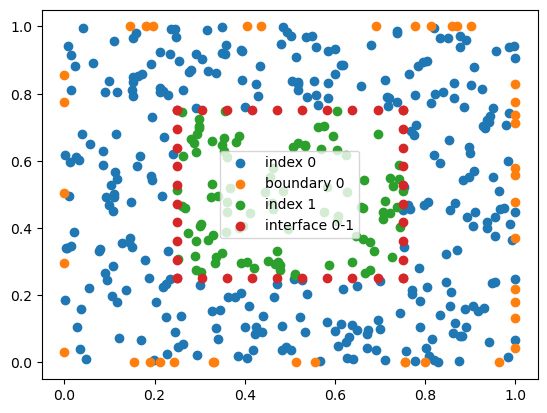

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

for i, pinn in enumerate(xpinn.PINNs):
    checkout = pinn.interior
    print(pinn.interior.shape)
    plt.scatter(checkout[:, 0], checkout[:, 1], label=f"index {i}")
    if pinn.boundary.size != 0:
        print(pinn.boundary.shape)
        plt.scatter(pinn.boundary[:, 0], pinn.boundary[:, 1], label=f"boundary {i}")

for interface in xpinn.Interfaces:
    a, b = interface.indices
    p = interface.points
    print(p.shape)
    plt.scatter(p[:, 0], p[:, 1], label=f"interface {a}-{b}")

plt.legend()

### PINN Formalization
We only consider boundary loss for the outer PINN.

### Setting the loss function
We create a base function for initializing the boundary loss functions, which is relatively simple in this case. 

In [4]:
from typing import Callable
from type_util import Params
from base_network import neural_network

LFunc = Callable[[Params, dict[str, Array]], Array]

model = neural_network(activation)
v_model = vmap(model, (None, 0))


def boundary_loss_factory(target: float | Array) -> LFunc:
    def boundary_loss(params: Params, points: dict[str, Array]) -> Array:
        pts = points["boundary"]
        eval = v_model(params, pts)
        return np.mean((eval - target) ** 2)

    return boundary_loss

In [5]:
def interior_loss_factory(index: int, rhs: float) -> LFunc:

    def hess(params):
        return hessian(lambda x: model(params, x))

    def residual(params, x):
        return np.trace(hess(params)(x)[0]) - rhs

    v_residual = jit(vmap(residual, (None, 0)))
    xpinn.PINNs[index].v_residual = v_residual

    def interior_loss(params: Params, points: dict[str, Array]) -> Array:
        pts = points["interior"]
        return np.mean(v_residual(params, pts) ** 2)

    return interior_loss

Setting the boundary and interior loss

In [6]:
p0, p1 = xpinn.PINNs

p0.boundary_loss = boundary_loss_factory(0.0)

p0.interior_loss = interior_loss_factory(0, 0.0)  # implementing rhs
p1.interior_loss = interior_loss_factory(1, 1.0)

Setting the interface loss

In [7]:
def interface_loss_factory(i: int, j: int) -> LFunc:
    a, b = sorted([i, j])
    pi = xpinn.PINNs[i]

    def interface_loss(params: Params, args: dict[str, Array]) -> Array:
        inter_points = args[f"interface {a}{b}"]
        res_j = args[f"interface res {j}"]
        res_ij = np.mean((pi.v_residual(params, inter_points) - res_j) ** 2)
        # res_ij = 0

        val_j = args[f"interface val {j}"]
        avg_ij = np.mean(((v_model(params, inter_points) - val_j) / 2) ** 2)
        # avg_ij = 0

        return 80 * (res_ij + avg_ij)

    return interface_loss

In [8]:
p0.interface_loss = interface_loss_factory(0, 1)
p1.interface_loss = interface_loss_factory(1, 0)

In [9]:
shapes = [[2] + [20] * 9 + [1]] * 2
optimizer = optax.adam(learning_rate=0.0001)
xpinn.initialize_params(shapes, optimizer)

In [10]:
n_iter = 20000
losses = xpinn.run_iters(n_iter)

2024-03-14 15:25:24.276801: E external/xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_update_iteration] Slow compile? XLA was built without compiler optimizations, which can be slow. Try rebuilding with -c opt.
********************************
2024-03-14 15:25:24.539397: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 10.268284s

********************************
[Compiling module jit_update_iteration] Slow compile? XLA was built without compiler optimizations, which can be slow. Try rebuilding with -c opt.
********************************


0.00% iter = 0 of 20000: Total loss = 243.85888025113385
10.00% iter = 2000 of 20000: Total loss = 0.18003922191665916
20.00% iter = 4000 of 20000: Total loss = 0.03605166884353724
30.00% iter = 6000 of 20000: Total loss = 0.0075156491499703305
40.00% iter = 8000 of 20000: Total loss = 0.003402419424859146
50.00% iter = 10000 of 20000: Total loss = 0.002026557209633582
60.00% iter = 12000 of 20000: Total loss = 0.0015491982068248714
70.00% iter = 14000 of 20000: Total loss = 0.0018487114354652015
80.00% iter = 16000 of 20000: Total loss = 0.00131470478741075
90.00% iter = 18000 of 20000: Total loss = 0.001298635040069903
100.00% iter = 20000 of 20000: Total loss = 0.0012913413211121851


Text(0.5, 1.0, 'Loss per Pinn over 20000 epochs')

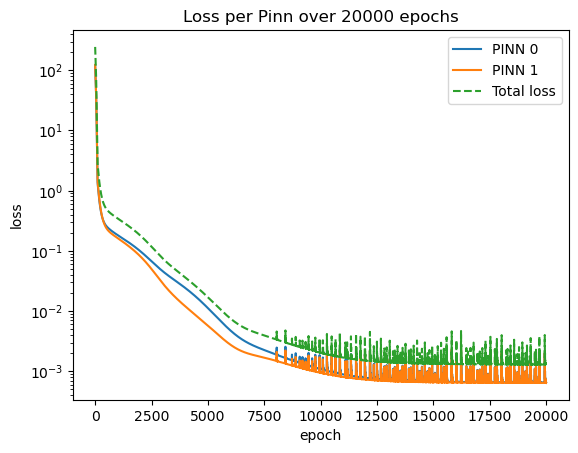

In [11]:
a_losses = losses
t_0 = 0
t_end = min(20000, n_iter)
t = np.arange(t_0, t_end)

for i in range(2):
    plt.plot(t, a_losses[i, t_0:t_end], label=f"PINN {i}")
plt.plot(t, np.sum(a_losses, axis=0)[t_0:t_end], "--", label="Total loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.yscale("log")
plt.legend()
plt.title(f"Loss per Pinn over {n_iter} epochs")

In [12]:
points, predictions = xpinn.predict(file_test)
total_pred = np.concatenate(predictions)
min_, max_ = total_pred.min(), total_pred.max()
# min_, max_ = 0, 1

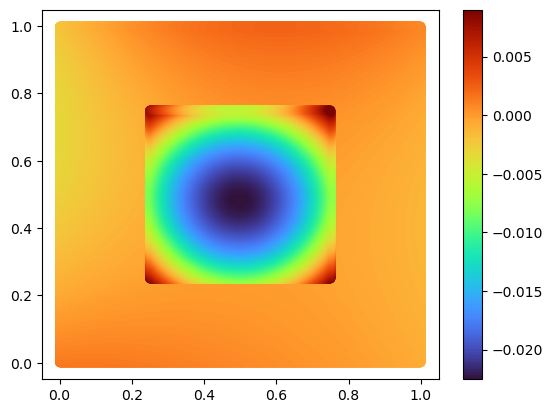

In [13]:
for point, pred in zip(points, predictions):
    plt.scatter(point[:, 0], point[:, 1], c=pred, cmap="turbo")
    plt.clim(min_, max_)

plt.colorbar()

In [14]:
p1 = xpinn.PINNs[1]
p1.loss(p1.params, xpinn.main_args[1])

Array(0.00064051, dtype=float64)

In [15]:
p0 = xpinn.PINNs[0]
p0.loss(p0.params, xpinn.main_args[0])

Array(0.00065077, dtype=float64)

In [16]:
p0.interface_loss(p0.params, xpinn.main_args[0])

Array(0.00063904, dtype=float64)

In [17]:
p0.boundary_loss(p0.params, xpinn.main_args[0])

Array(2.07284906e-06, dtype=float64)

In [18]:
p0.interior_loss(p0.params, xpinn.main_args[0])

Array(9.65856389e-06, dtype=float64)

In [19]:
p0.v_residual(p0.params, xpinn.main_args[0]["interior"])

Array([-2.49565978e-03, -4.40930327e-03,  4.45726316e-03,  2.09846986e-03,
       -3.92100657e-04, -3.17216860e-03, -3.00189075e-04,  2.78273046e-03,
       -4.34152095e-03,  1.15116987e-03, -8.06324821e-03,  4.18668170e-04,
       -2.30796263e-03, -2.50630633e-04,  5.49713405e-03, -2.98664745e-03,
        1.81007333e-04, -6.83421780e-04, -4.31933561e-04, -2.08283036e-03,
       -1.84135013e-03, -1.66103577e-03,  3.02412065e-03, -5.08545379e-03,
        2.72228408e-03,  2.04681929e-03,  2.30926829e-03, -1.76967113e-03,
        3.36971956e-03,  3.29160279e-03,  1.08014706e-03,  3.14184335e-03,
        9.63025476e-04, -1.92430340e-05,  2.44485632e-03, -9.78004348e-04,
        3.37467073e-03,  1.86028863e-03, -7.27931249e-06, -1.79850177e-03,
       -2.36363328e-03, -1.32418934e-04,  1.77700869e-03, -9.09225939e-04,
       -5.09036576e-03, -7.06818598e-04,  6.42507761e-03, -9.18346668e-04,
        1.93690336e-03, -2.14590366e-03, -9.33301429e-04,  2.39413150e-03,
       -4.02308640e-03, -

In [20]:
p1.v_residual(p1.params, xpinn.main_args[1]["interior"]).shape

(101,)

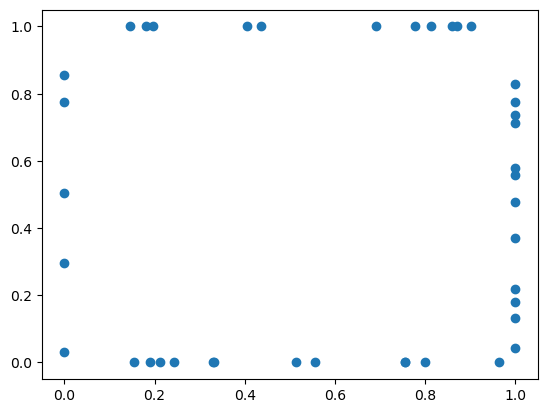

In [21]:
plt.plot(
    xpinn.main_args[0]["boundary"][:,
                                   0], xpinn.main_args[0]["boundary"][:, 1], "o"
)

In [22]:
rhs = 0.0


def hess(params):
    return hessian(lambda x: model(params, x))


def residual(params, x):
    return np.trace(hess(params)(x)[0]) - rhs

In [23]:
x = xpinn.main_args[0]["interior"][0]
np.trace(hess(p0.params)(x))

Array([-0.02385581,  0.00499817], dtype=float64)

In [24]:
hess(p0.params)(x)[0]

Array([[-0.02385581,  0.00499817],
       [ 0.00499817,  0.02136015]], dtype=float64)